# Kona Coffee IBM Deep Learning

This anaylisis will cover the Kona Coffee dataset I have been working with and utilize deep learning approaches to classify the coffee berries into various lifecycles. We will explore different deep learning models, utilizing transfer learning, and compare them to a traditional machine learning approach.

## Dataset

The kona coffee berry dataset consists of series of images taking from a variety of coffee plants colocated within a production field. The images were carefully annotated with the Segment Anything model to produce instance masks which are then cropped down to just the bounding box. Finally, hundreds of berries were annotated to give them 3 lifecycles: 'unripe', 'ripening' and 'ripe'.

## Objective

The main objective is to compare and contrast different Deep Learning models utilizing transfer learning to see if the berry mask can be classified correctly. Furthermore, we will compare the metrics with a niave machine learning approach to see if the deep learning models improve upon the results. The goal here is to be able to take images of coffee berries within a production field, and classify them into their lifecycles. This will allow farmers to better predict yields and plan harvests accordingly.

# Prepare the Dataset

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette('rainbow')
sns.set_context('talk')

new_basedir = '/home/jack/Documents/kona_coffee/imagemasks'

df = pd.read_csv('/home/jack/Documents/classified_masks.csv')

df['image'] = df['image'].apply(lambda x: os.path.join(new_basedir, os.path.basename(x)))

# filter if they don't exist on disk
df = df[df['image'].apply(lambda x: os.path.exists(x))]

df

,image,lifecycle
0,/home/jack/Documents/kona_coffee/imagemasks/10...,ripening
1,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe
2,/home/jack/Documents/kona_coffee/imagemasks/10...,ripening
3,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
4,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
...,...,...
2282,/home/jack/Documents/kona_coffee/imagemasks/10...,ripening
2283,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
2284,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe
2285,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2287 entries, 0 to 2286
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      2287 non-null   object
 1   lifecycle  2287 non-null   object
dtypes: object(2)
memory usage: 53.6+ KB


In [34]:
df['lifecycle'].value_counts()

unripe      1371
ripe         532
ripening     384
Name: lifecycle, dtype: int64

We do have a very unbalanced dataset. This is due to the fact that since this is a production farm, they typically want to harvest most if not all the ripe berries! Leaving way more unripe berries. We can sample the dataset down to 500 samples per class to make it more balanced. This will duplicate some of the images, but it will be a good starting point.

In [2]:
# we set replace to allow for oversampling
df = df.groupby('lifecycle').sample(500, random_state=42, replace=True)

df['lifecycle'].value_counts()

ripe        500
ripening    500
unripe      500
Name: lifecycle, dtype: int64

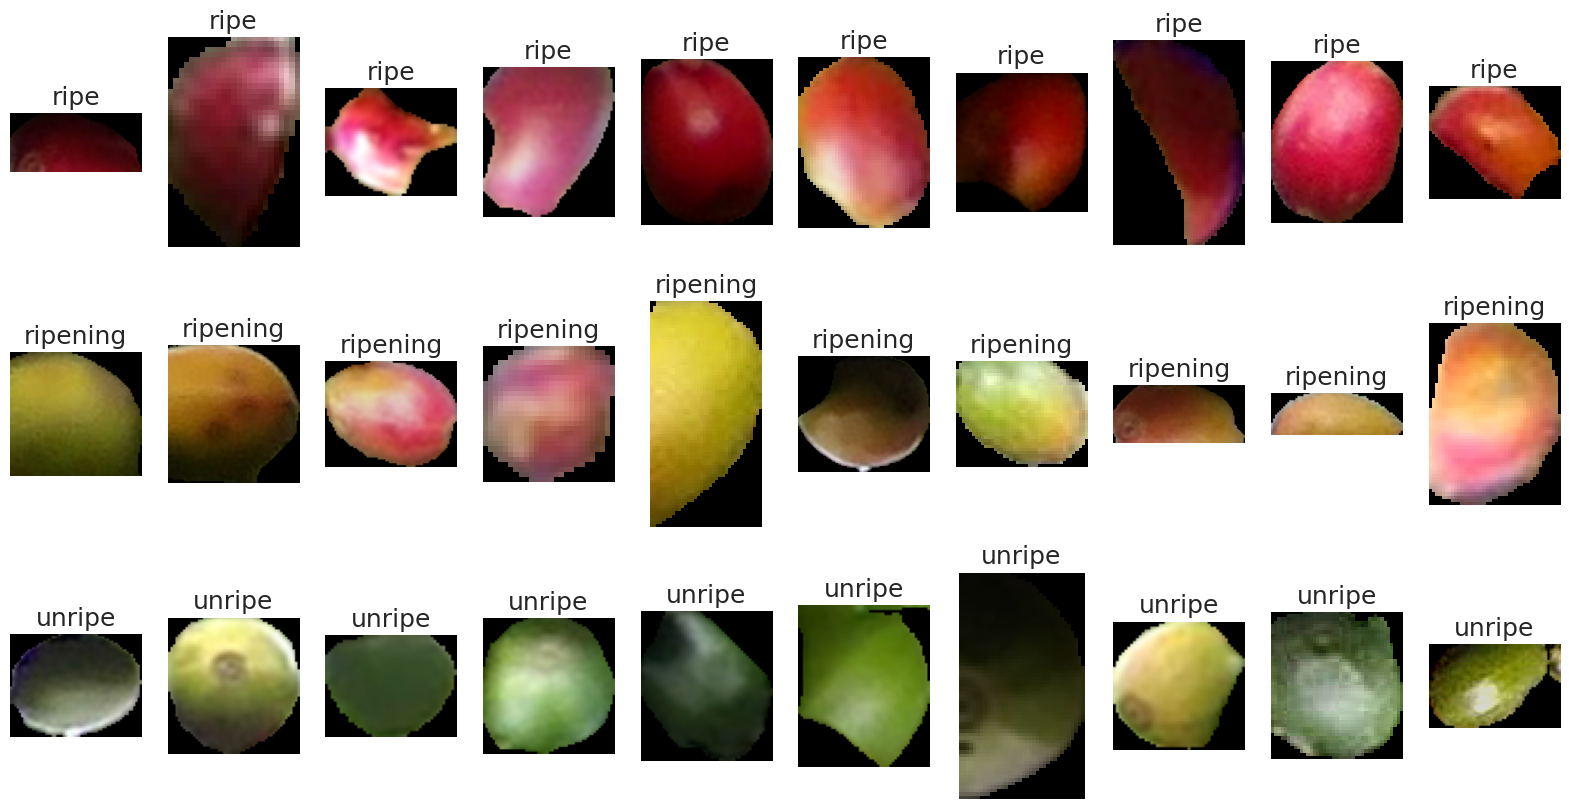

In [39]:
# display 15 images, 5 for each class
fig, ax = plt.subplots(3, 10, figsize=(20, 10))
ax = ax.ravel()
for i, (lifecycle, group) in enumerate(df.groupby('lifecycle')):
    for j, (_, row) in enumerate(group.sample(10).iterrows()):
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i*10+j].imshow(img)
        ax[i*10+j].set_title(lifecycle)
        ax[i*10+j].axis('off')

As you can see in the image above, we have 3 lifecycles where it appears visually that the main difference is the color of the berry. The berries are of various sizes and shapes as some may be hidden behind others, under a leaf, or some other obstruction.

As a baseline, let's retrieve some features of the berries and see if we can classify them using a simple machine learning approach.

In [43]:
mdf = df.copy()

for row in tqdm(mdf.itertuples(), total=len(mdf)):
    img = cv2.imread(row.image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # find 5 points randomly that are not black
    points = []
    while len(points) < 5:
        x = np.random.randint(0, img.shape[1])
        y = np.random.randint(0, img.shape[0])
        if not np.all(img[y, x] == 0):
            points.append((x, y))
            
    # find the average color of those points
    red = np.mean([img[y, x][0] for x, y in points])
    green = np.mean([img[y, x][1] for x, y in points])
    blue = np.mean([img[y, x][2] for x, y in points])
    
    # add to the dataframe
    mdf.loc[row.Index, 'red'] = red
    mdf.loc[row.Index, 'green'] = green
    mdf.loc[row.Index, 'blue'] = blue
    
mdf

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1325.30it/s]


,image,lifecycle,red,green,blue
395,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe,83.8,37.6,28.8
1934,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe,60.0,5.4,12.2
1091,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe,151.8,50.8,58.4
415,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe,136.8,22.4,28.8
257,/home/jack/Documents/kona_coffee/imagemasks/10...,ripe,132.2,33.8,30.8
...,...,...,...,...,...
2053,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe,102.8,119.8,67.6
1418,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe,130.4,152.2,79.8
1179,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe,71.4,95.8,66.4
779,/home/jack/Documents/kona_coffee/imagemasks/10...,unripe,140.0,179.2,75.8


# Baseline Machine Learning Model

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

x = MinMaxScaler().fit_transform(mdf[['red', 'green', 'blue']])
y = LabelEncoder().fit_transform(mdf['lifecycle'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       104
           1       0.82      0.67      0.74        86
           2       0.89      0.95      0.92       110

    accuracy                           0.86       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.86      0.85       300



<Axes: >

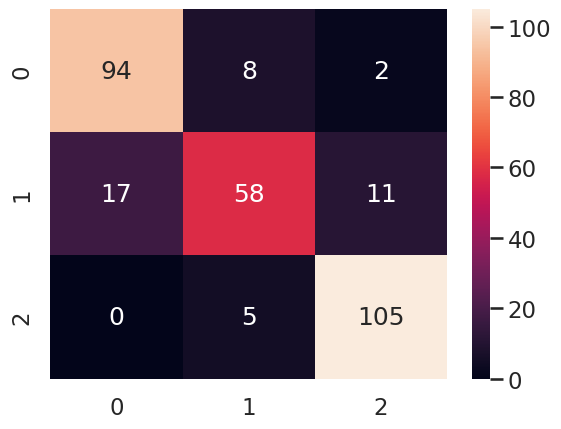

In [49]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

Using the simple, yet powerful, logisitic regression model, we get some fairly good results. Overall, since we have a balanced dataset, we trust our accuracy score of 86%. However, the precision and recall are not balanced for all classes. Class 1 has a recall of only 67% resulting in a lower F1 score.

Looking at the confusion matrix, the culprit is the class 1 berries. Intuitively, ripening may be a more difficult class to prediction as they are in a state between unripe and ripe. But, for our purposes, this may not be a problem for farmers as they can simply use the "ripening" class as a baseline to judge if the berries are starting to become ready to harvest.

But this a Deep Learning analysis, so let's get to it!

# Deep Learning Approaches

For the different deep learning approaches, we will use a variety of models. Some utilizing transfer learning, and others we will built from the ground up. In addition, we will also utilize data augmentation techniques to help use present the model with a more robust dataset.

## Simple DNN with Machine Learning Features

We will start with a simple DNN model that will take in the machine learning features we extracted from the berries (simply the mean of the RGB channels)

## Simple CNN

Next, we will built our own convolutional neural network and extract features directly from the images.

## Transfer Learning

Finally, we will utilize transfer learning to see if we can improve upon the results of the simple CNN. We will explore the VGG16, ResNet50, and InceptionV3 models.

In [4]:
def graph_history_metrics(history):
    cols = 3
    rows = int(np.ceil(len(history.history.keys()) / cols))
    
    height = 5 * rows

    fig, axes = plt.subplots(rows, cols, figsize=(20, height))
    axes = axes.flatten()

    # pad the axes
    fig.tight_layout(pad=3.0)

    fig.suptitle('Model Metrics')

    keys = history.history.keys()

    for i, key in enumerate(keys):
        
        final_val = history.history[key][-1]
        
        axes[i].axhline(final_val, ls='--', color='r')
        axes[i].plot(history.history[key], label=key)
        axes[i].set_title(f'{key}. Final: {final_val:.4f}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(key)
        axes[i].legend()

## Simple DNN with Machine Learning Features

Epoch 96: early stopping
10/10 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       104
           1       0.82      0.83      0.82        86
           2       0.95      0.95      0.95       110

    accuracy                           0.90       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.90      0.90      0.90       300



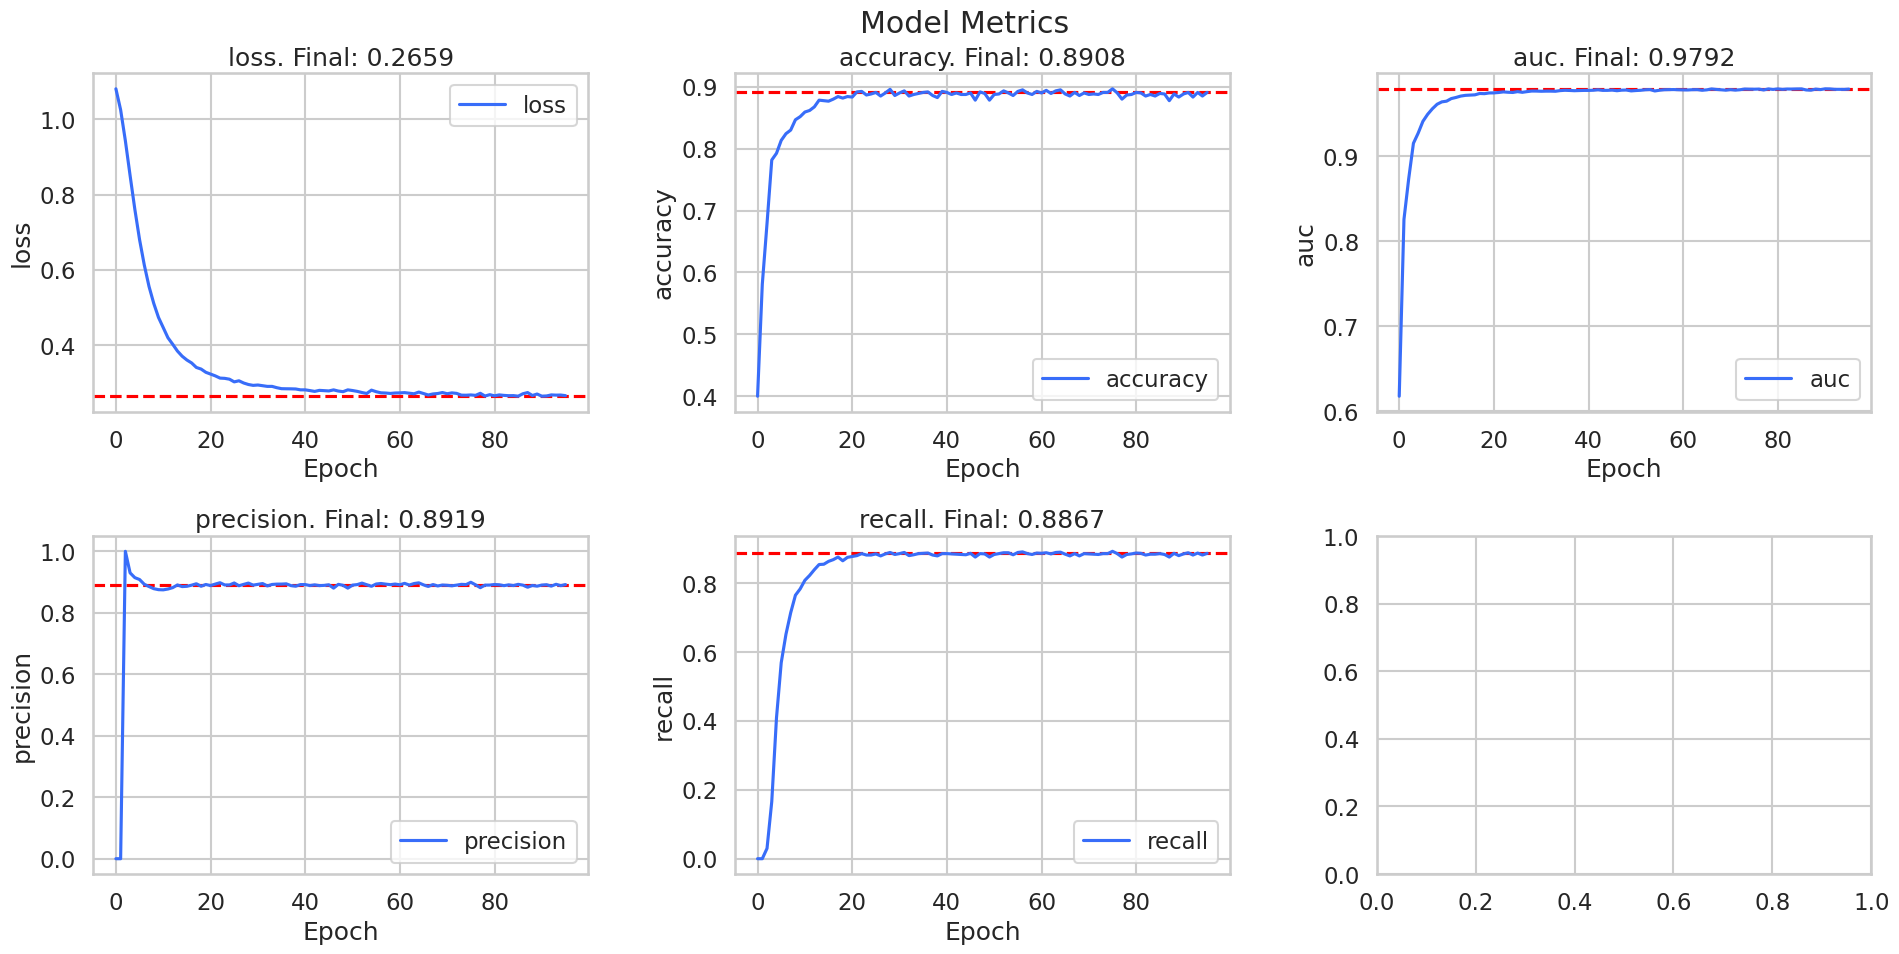

In [91]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

x = MinMaxScaler().fit_transform(mdf[['red', 'green', 'blue']])
y = LabelEncoder().fit_transform(mdf['lifecycle'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

history = model.fit(
    x_train,
    pd.get_dummies(y_train),
    callbacks=[early_stop],
    epochs=100,
    verbose=0
)

graph_history_metrics(history)

y_pred = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, y_pred))

Without any regularization, l1 or l2, dropout, batch normalization, or any hyperparameter tuning of optimizers or activation functions, we get really great results. These results are already better than our baseline model too!

The models performance on the test set suggests that the model is not overfitting, but it does appear from the metrics that we could have stopped training around 40 epochs. We could also deploy a validation set in order to help the early stopping callback.

But, when we observe the recalls and precisions, we still see the class 1 is the worst performing class.This is further evidence that our intuition may be correct that the ripening class is the most difficult to classify.

## Simple CNN

In [6]:
# need the original dataframe because our images are what we are feeding into the model!
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)

For the simple CNN, we are going to utilize the preprocessing layers from Keras for data augmentation. We can add zooming, rotations, brightness adjustments, and more to help the model generalize better. We will also do shuffling as a form of regularization.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess(image):
    image = cv2.resize(image, (64, 64))
    return image

datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rescale=1./255,
    zoom_range=[0.5, 1.0],
    rotation_range=90,
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
    vertical_flip=True,
)

train_gen = datagen.flow_from_dataframe(
    df_train,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(64, 64),
    class_mode='categorical',
    validation_split=0.2,
    seed=42,
    batch_size=16,
    shuffle=True
)

test_gen = datagen.flow_from_dataframe(
    df_test,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(64, 64),
    class_mode='categorical',
    seed=42,
    batch_size=16,
    shuffle=False
)

Found 1200 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


2023-11-19 17:02:22.091201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-19 17:02:25.895019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 22: early stopping
 4/10 [===========>..................] - ETA: 0s

2023-11-19 17:04:10.245392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

        ripe       0.77      1.00      0.87        33
    ripening       0.83      0.74      0.78        39
      unripe       1.00      0.93      0.96        82

    accuracy                           0.90       154
   macro avg       0.87      0.89      0.87       154
weighted avg       0.91      0.90      0.90       154



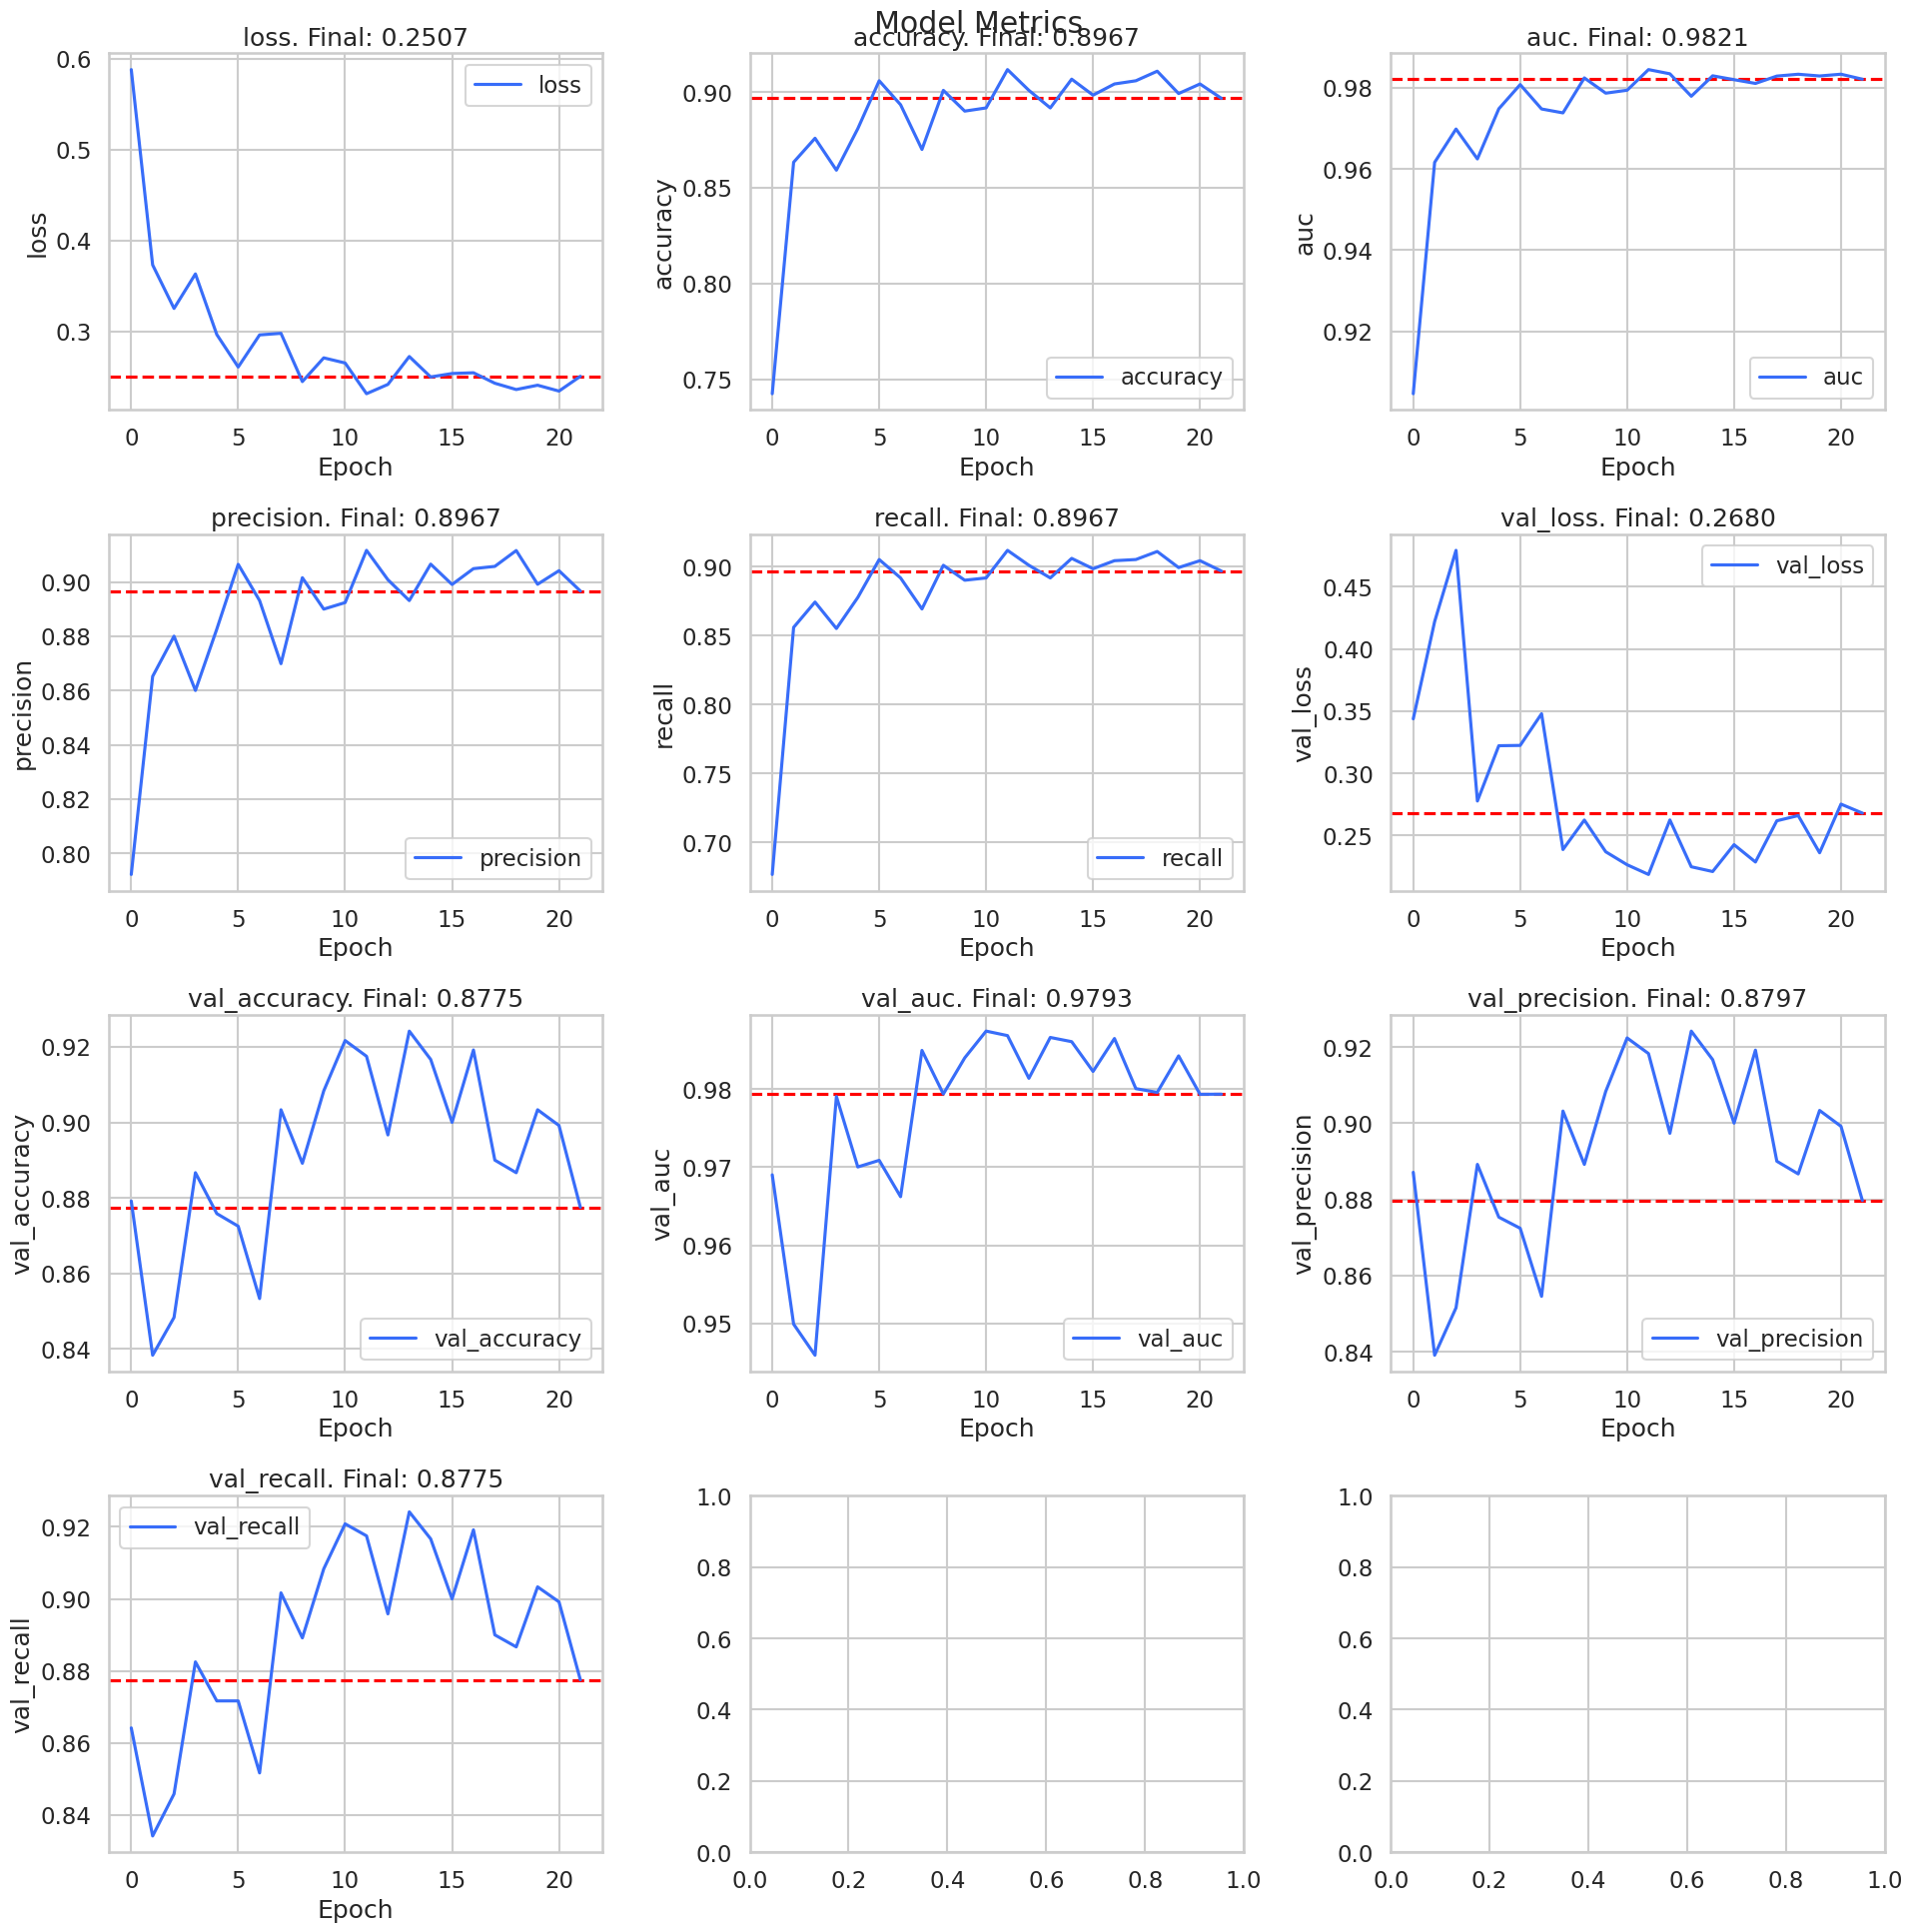

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)],
    epochs=300,
    verbose=0
)

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_test = test_gen.labels

print(classification_report(y_test, y_pred, target_names=test_gen.class_indices.keys()))

graph_history_metrics(history)

And with our very simple CNN, we also get very good results. Again, the precision and recall are off on the ripening class, but that is something we can live with. With this model, I believe that it would be more accurate given more convolutional layers and maybe more regularization. But, with transfer learning, we may be able to get better results.

## Transfer Learning

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobile_preprocess
from keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.callbacks import EarlyStopping

def resnet_function(image):
    image = cv2.resize(image, (224, 224))
    image = resnet_preprocess(image)
    return image

def vgg_function(image):
    image = cv2.resize(image, (224, 224))
    image = vgg_preprocess(image)
    return image

def mobile_function(image):
    image = cv2.resize(image, (224, 224))
    image = mobile_preprocess(image)
    return image

def create_data_gens(preprocess):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess,
        zoom_range=[0.5, 1.0],
        rotation_range=90,
        brightness_range=[0.2, 1.0],
        horizontal_flip=True,
        vertical_flip=True,
    )

    train_gen = datagen.flow_from_dataframe(
        df_train,
        directory=None,
        x_col='image',
        y_col='lifecycle',
        target_size=(224, 224),
        class_mode='categorical',
        validation_split=0.2,
        seed=42,
        batch_size=16,
        shuffle=True
    )

    test_gen = datagen.flow_from_dataframe(
        df_test,
        directory=None,
        x_col='image',
        y_col='lifecycle',
        target_size=(224, 224),
        class_mode='categorical',
        seed=42,
        batch_size=16,
        shuffle=False
    )
    
    return train_gen, test_gen

Found 1200 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


2023-11-19 17:16:41.185249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-19 17:16:58.850661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 58: early stopping


2023-11-19 17:39:51.241222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 4s 295ms/step
              precision    recall  f1-score   support

        ripe       0.70      1.00      0.82        33
    ripening       1.00      0.62      0.76        39
      unripe       0.99      1.00      0.99        82

    accuracy                           0.90       154
   macro avg       0.90      0.87      0.86       154
weighted avg       0.93      0.90      0.90       154



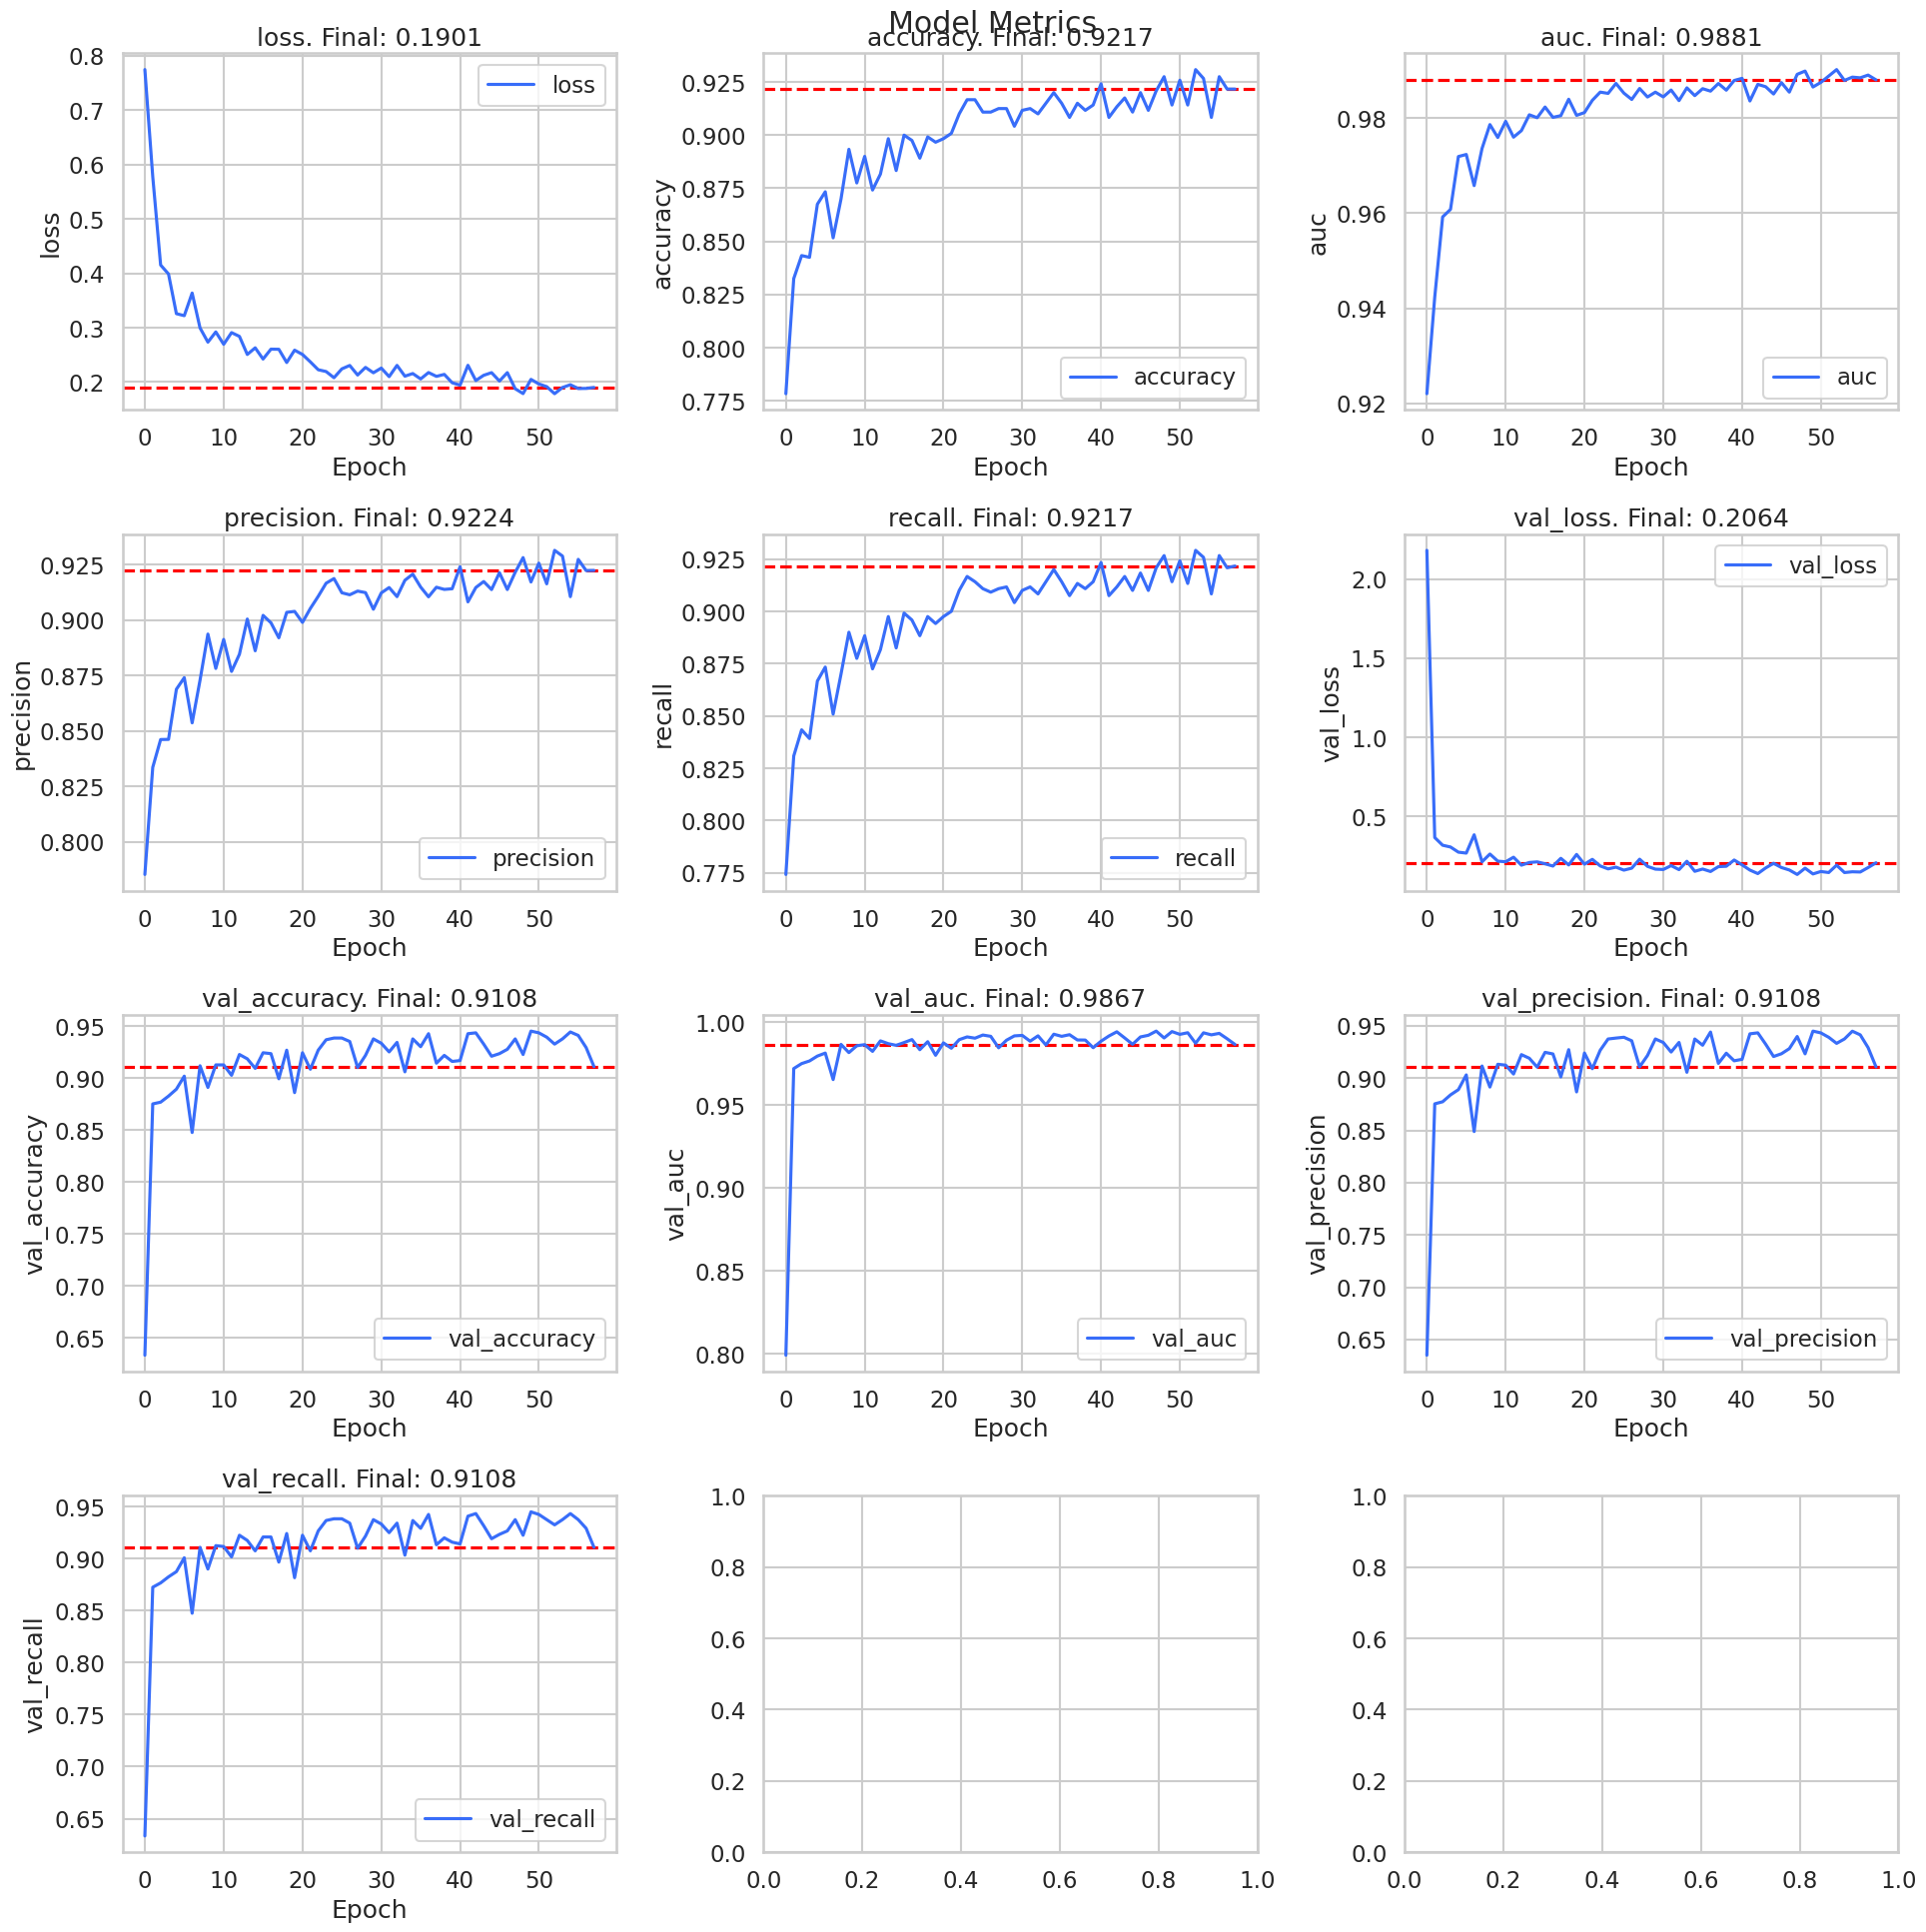

In [22]:
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

for layer in resnet.layers:
    layer.trainable = False
    
outputs = resnet.layers[-1].output

outputs = Flatten()(outputs)
outputs = Dense(1024, activation='relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(512, activation='relu')(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs=resnet.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

train_gen, test_gen = create_data_gens(resnet_function)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=False
)

# train model
history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[early_stopping],
    epochs=300,
    verbose=0
)

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_test = test_gen.labels

print(classification_report(y_test, y_pred, target_names=test_gen.class_indices.keys()))

graph_history_metrics(history)

23 minutes later, the ResNet model has finished. Freezing the model for transfer learning, it is clear that the model does exceptionally well on the test set. Overall, the accuracy is 90%. However, the precision and recall are still off for the ripening class. In addition, the precision is off on the ripe class as well.

Recalling that a lower precision means that we are getting more false positives, we can see that the model is classifying more berries as ripe than they actually are. This may not be a bad thing as berries that rippen will need to be harvested quicker before they become overripe. In a way, the model is sensitive to the fact that berries are becoming riper.

Found 1200 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


2023-11-19 17:50:15.500827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-19 17:50:16.966147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-19 17:50:17.537113: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-19 17:50:17.901637: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could 

Epoch 35: early stopping


2023-11-19 18:04:16.053089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 9/10 [==========================>...] - ETA: 0s

2023-11-19 18:04:18.277930: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-19 18:04:18.277978: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-19 18:04:18.428053: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


10/10 [==============================] - 5s 470ms/step
              precision    recall  f1-score   support

        ripe       0.80      0.97      0.88        33
    ripening       0.91      0.79      0.85        39
      unripe       0.97      0.95      0.96        82

    accuracy                           0.92       154
   macro avg       0.90      0.91      0.90       154
weighted avg       0.92      0.92      0.92       154



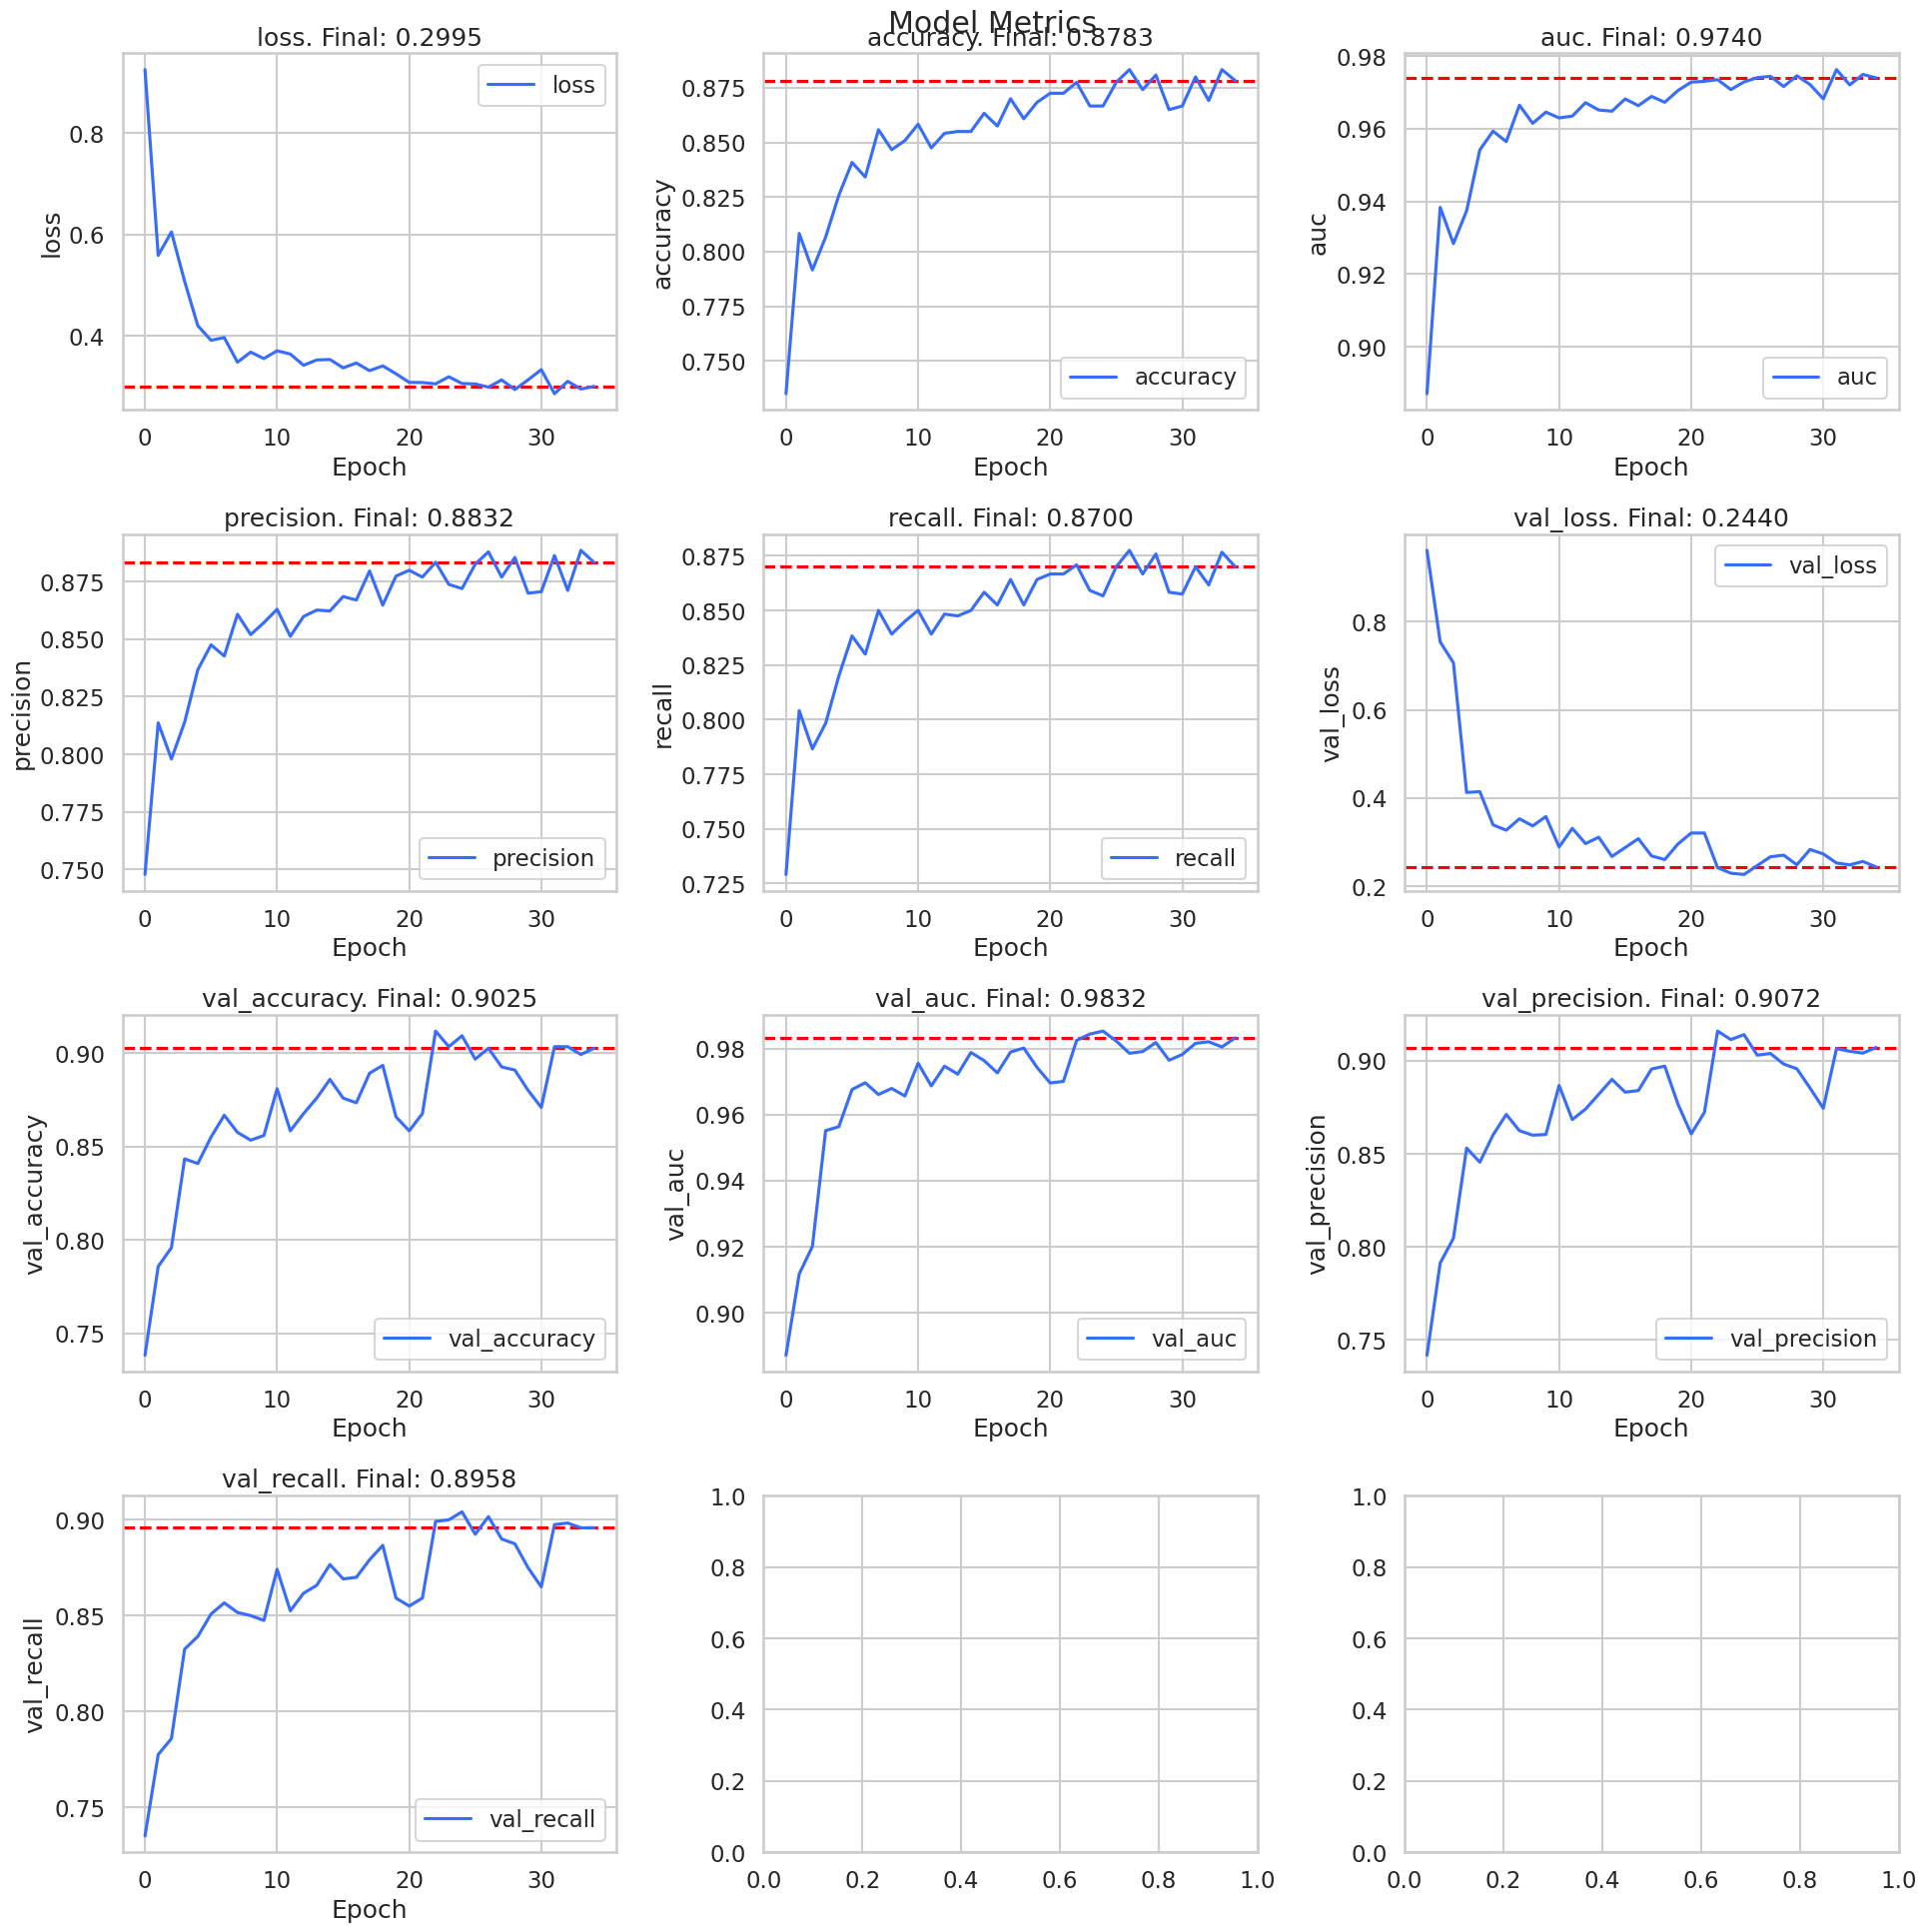

In [12]:
vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

for layer in vgg16.layers:
    layer.trainable = False
    
outputs = vgg16.layers[-1].output

outputs = Flatten()(outputs)
outputs = Dense(1024, activation='relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(512, activation='relu')(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs=vgg16.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

train_gen, test_gen = create_data_gens(vgg_function)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=False
)

# train model
history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[early_stopping],
    epochs=300,
    verbose=0
)

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_test = test_gen.labels

print(classification_report(y_test, y_pred, target_names=test_gen.class_indices.keys()))

graph_history_metrics(history)

With the VGG16 model, we get slight more unbalanced precision and recall, but our overall accuracy is 92%. I should note that I also almost ran out of GPU memory with the VGG16 model. My current GPU: GTX 960, only has 2GB of VRAM. Time to upgrade! Now for the last model: MobileNet

9406464/9406464 [==============================] - 2s 0us/step
Found 1200 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


2023-11-19 18:07:51.768565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-19 18:08:07.868943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 66: early stopping


2023-11-19 18:33:01.653679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 252ms/step
              precision    recall  f1-score   support

        ripe       0.58      0.94      0.72        33
    ripening       0.71      0.62      0.66        39
      unripe       0.90      0.73      0.81        82

    accuracy                           0.75       154
   macro avg       0.73      0.76      0.73       154
weighted avg       0.78      0.75      0.75       154



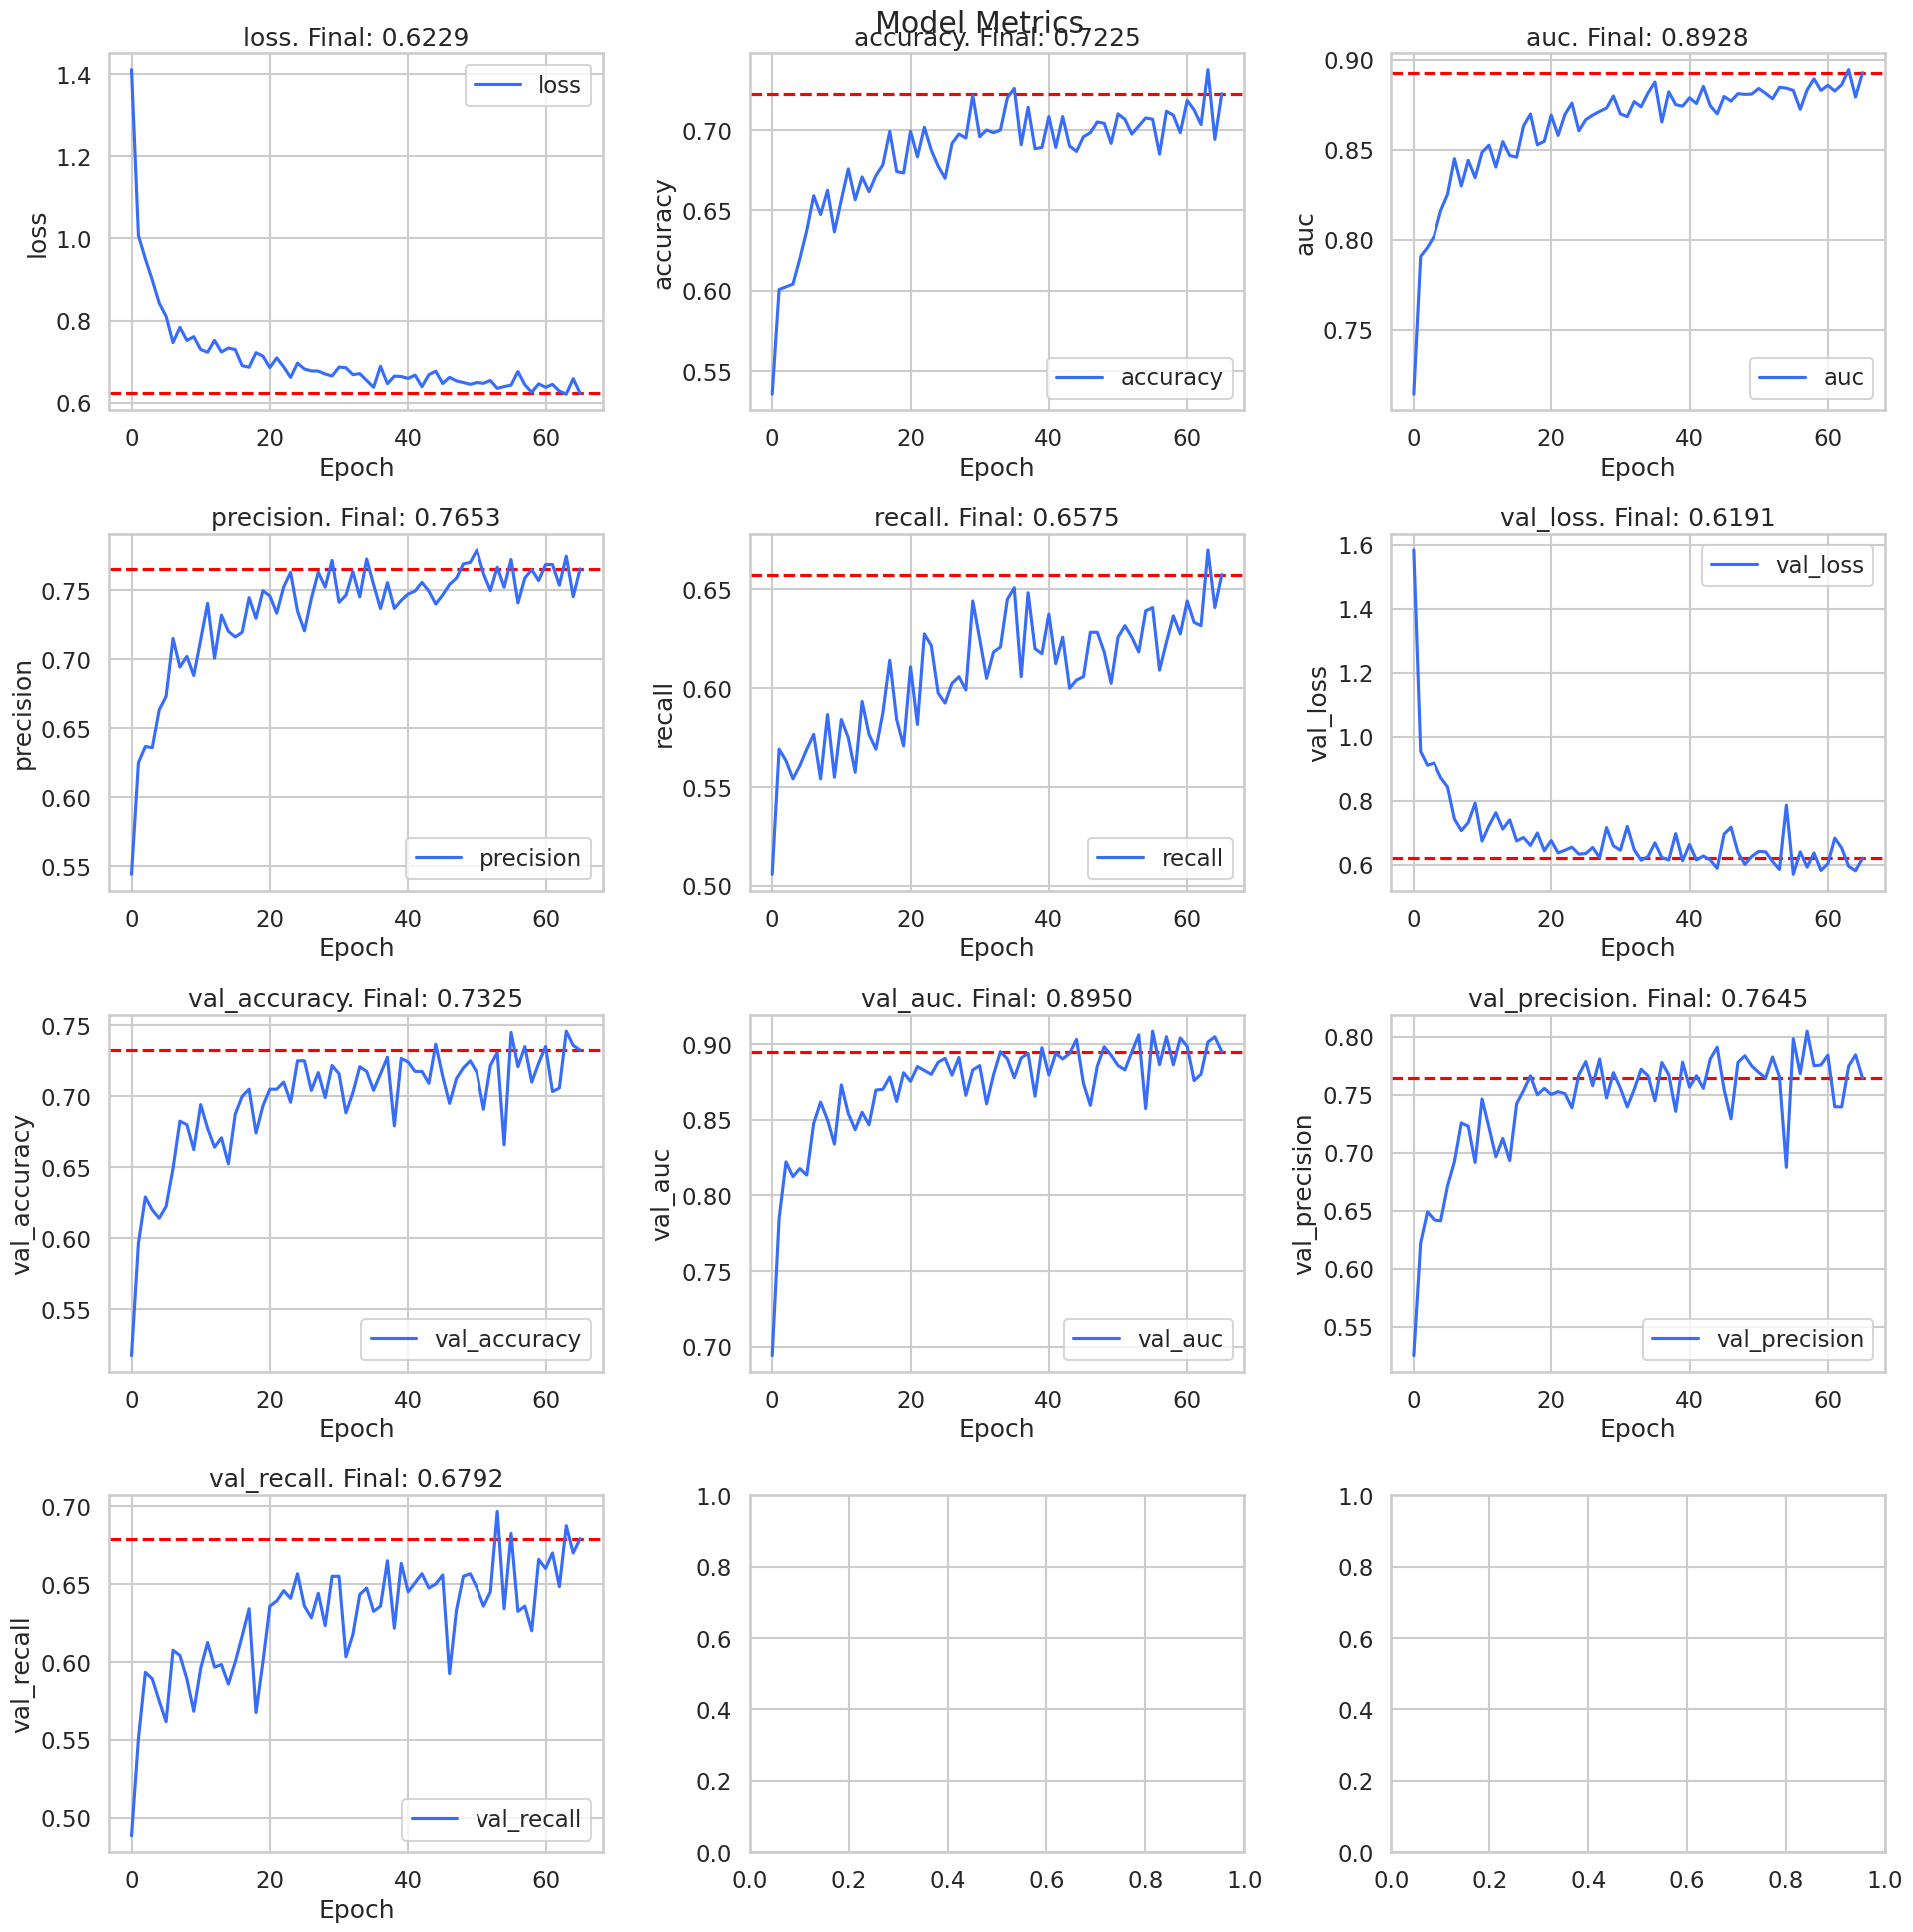

In [14]:
mobile = MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

for layer in mobile.layers:
    layer.trainable = False
    
outputs = mobile.layers[-1].output

outputs = Flatten()(outputs)
outputs = Dense(1024, activation='relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(512, activation='relu')(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs=mobile.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

train_gen, test_gen = create_data_gens(mobile_function)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=False
)

# train model
history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[early_stopping],
    epochs=300,
    verbose=0
)

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_test = test_gen.labels

print(classification_report(y_test, y_pred, target_names=test_gen.class_indices.keys()))

graph_history_metrics(history)

The mobilenet model took the longest to train, and actually performed the worst out of all the other models. With different initialization, regularization, optimizers, I'm sure it would perform better.

# Final Remarks

Comparing the different models, LogisiticRegression, SimpleDNN, SimpleCNN, ResNet50, VGG16, and MobileNet, we can see that the deep learning models do perform better than the traditional machine learning approach. However, the training times and workload with deep learning is significantly higher. Given the objective, and it's underlying goal, it wouldn't be extremely beneficial to use deep learning other than a SimpleDNN model. If we were anaylzing more features of the berries, such as the size, shape, and color, then a deep learning approach would be more beneficial.

Using deep learning would be beneficial in producing the dataset, where the variety of coffee berries, hiding amoungst the leaves, presents a task that is difficult to train a traditional ML model on. Segment Anything, a automated image segmentation tool, was used to produce the dataset. From there, a more specific and faster model could be trained to produce the masks. This would be a great use case for deep learning.

The next steps for this project would be to produce more data, and train a SimpleDNN to do the classification, or stick with a LogisiticRegression or DecisionTree model in order to have the descriptive capabilities that come with them. But, throughout the course of the analysis, we have shown that deep learning can be used to classify coffee berries into their lifecycles with a high degree of accuracy: 90% or more!